In [11]:
####################################################################################################
# CR.ProductRegrid.ipynb
# Karl Lapo July/2015
####################################################################################################
# Regrids all data to MTCLIM grid, plot mean standard deviation for each grid
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
from netCDF4 import num2date, date2num
import numpy as np
from datetime import datetime, timedelta
import pickle
import pandas as pd
import xray
import scipy

# OS interaction
import sys
import os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Custom packages
import kray
import kgraph

#### Directory Lists
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dir_data = dir_pre+'SnowHydrology/proj/CloudClimatology/data'
dir_print = dir_pre+'SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_WRF = '/WRF'

# Directory for basemap pickle files
dir_bmap = dir_pre+'SnowHydrology/proj/CloudClimatology/data/basemap'

#### Flags
flagAlignProduct = 1 # 1: load product netcdfs, regrid, align, save to netcdf.
                     # 0: load regridded netcdf

In [3]:
##### Re-Gridding Function
# Converts from_xray_ds spatial resolution to to_xray_ds using a nearest neighbor approach.
# Assumes arrays are ['time','lat','lon']
def xray_regrid(from_xray_ds,to_xray_ds,field):
    ## Coordinates to regrid to
    lat_rg = to_xray_ds.latitude.values
    nlat_rg = lat_rg.size
    lon_rg = to_xray_ds.longitude.values
    nlon_rg = lon_rg.size
    lonm_rg,latm_rg = np.meshgrid(lon_rg,lat_rg)
    
    ## Coordinates of original dataset
    lat_g = from_xray_ds.latitude.values
    nlat_g = lat_g.size
    lon_g = from_xray_ds.longitude.values
    nlon_g = lon_g.size
    lonm_g,latm_g = np.meshgrid(lon_g,lat_g)
    latm_g = np.reshape(latm_g[:],(nlat_g*nlon_g,1))
    lonm_g = np.reshape(lonm_g[:],(nlat_g*nlon_g,1))
    
    ## Combine coordinates
    grid_points = np.append(lonm_g[:],latm_g[:],axis=1)
    regrid_points = (lonm_rg,latm_rg)
    
    ## Interpolate in space dimension, along time dimension
    dates = from_xray_ds.time
    regrid = np.empty((dates.size,nlat_rg,nlon_rg))
    for ind,d in enumerate(dates):
        ## Use loc or sel here instead of values w/ indexing
        grid = np.reshape(np.squeeze(from_xray_ds[field].values[ind,:,:]),(nlat_g*nlon_g))
        regrid[ind,:,:] = scipy.interpolate.griddata(grid_points,grid,regrid_points,method='nearest') 
        
    ## Output to xray structure
    regrid_xray_ds = xray.Dataset({field: (['time','latitude','longitude'], regrid)},\
                                  coords={'time': dates,'latitude': lat_rg,'longitude':lon_rg})
    return(regrid_xray_ds)

In [67]:
#############
## netcdfs ##
#############

## Load products, regrid, align, output new netcdf
if flagAlignProduct:
    ## NLDAS ##
    os.chdir(dir_data+dir_NLDAS)
    nldas = xray.open_dataset('CA.NLDAS.irrad.monthly.nc')
    nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})

    ## SYN ##
    os.chdir(dir_data+dir_SYN)
    syn = xray.open_dataset('CA.SYN.irrad.monthly.nc')

    ## MTCLIM ##
    os.chdir(dir_data+dir_VIC)
    mtclim = xray.open_dataset('CA.MTCLIM.irrad.monthly.nc')

    ## WRF ##
    os.chdir(dir_data+dir_WRF)
    wrf = xray.open_dataset('CA.WRF.irrad.monthly.nc')
    wrf = wrf.rename({'lon':'longitude','lat':'latitude'})

    ## Re-grid to wrf spatial scale

    regrid_ds = {}
    regrid_ds['nldas'] = xray_regrid(nldas,wrf,'SWdwn')
    regrid_ds['syn'] = xray_regrid(syn,wrf,'SWdwn')
    regrid_ds['mtclim'] = xray_regrid(mtclim,wrf,'SWdwn')
    regrid_ds['wrf'] = wrf

    # Describe product names for iteration
    productNames = ['mtclim','nldas','syn','wrf']
    numProducts = np.size(productNames)

    # Aligned xray Dataset structure
    align_ds = xray.Dataset()
    for pr in productNames:
        align_ds[pr] = regrid_ds[pr].SWdwn

    # Output
    os.chdir(dir_data)
    align_ds.to_netcdf('SWdwn.AllProducts.Align.nc')

elif not flagAlignProduct:
    # Open previously formatted file
    os.chdir(dir_data)
    align_ds = xray.open_dataset('SWdwn.AllProducts.Align.nc')

## Remove 0 values from mtclim DataArray
tind,latind,lonind = np.nonzero(~np.isnan(align_ds.mtclim.where(align_ds.mtclim == 0).values))
align_ds.mtclim.values[tind,latind,lonind] = np.nan

print(align_ds)

<xray.Dataset>
Dimensions:    (latitude: 121, longitude: 120, time: 144)
Coordinates:
  * latitude   (latitude) float32 34.5252 34.5791 34.633 34.6869 34.7408 ...
  * longitude  (longitude) float32 -123.48 -123.416 -123.352 -123.288 ...
  * time       (time) datetime64[ns] 2000-01-31 2000-02-29 2000-03-31 ...
Data variables:
    mtclim     (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    nldas      (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    syn        (time, latitude, longitude) float64 nan nan nan nan nan nan ...
    wrf        (time, latitude, longitude) float64 nan nan nan nan nan nan ...


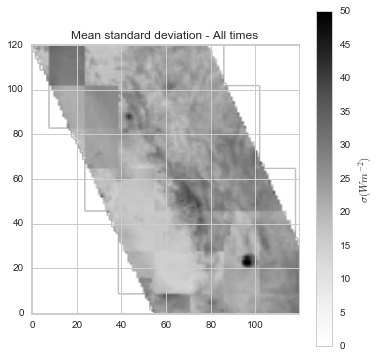

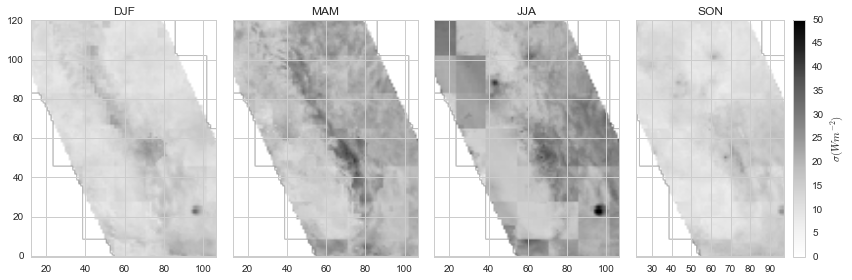

In [77]:
########################################################################
## Maps of mean standard deviation between products
########################################################################
# Combine ensemble members into a single DataArray
ds_comb = kray.combinevars(align_ds,productNames,'product','SWdwn')

### Mean - all periods
fig,ax = plt.subplots(1,1,figsize=(6,6))
imcol = ax.imshow(ds_comb.std(dim='product').mean(dim='time'),vmin=0,vmax=20,origin='lower')
colax = plt.colorbar(imcol)
colax.ax.set_ylabel('$\sigma (Wm^{-2})$')
ax.set_title('Mean standard deviation - All times')

# Print
os.chdir(dir_print)
fig.savefig('ProductDisagreement.png')
fig.savefig('ProductDisagreement.pdf')

### Seasonal
fig,axes = plt.subplots(1,4,sharey='row',figsize=(12,4))
seasons = ['DJF','MAM','JJA','SON']

for ax,s in zip(axes,seasons):
    # Mean - all periods
    imcol = ax.imshow(ds_comb.sel(time=(ds_comb['time.season'] == s)).std(dim='product').\
                      mean(dim='time'),vmin=0,vmax=20,origin='lower')
    ax.set_title(s)
    if ax == axes[-1]:
        colax = plt.colorbar(imcol)
        colax.ax.set_ylabel('$\sigma (Wm^{-2})$')
fig.tight_layout()

# Print
os.chdir(dir_print)
fig.savefig('ProductDisagreementSeasonal.png')
fig.savefig('ProductDisagreementSeasonal.pdf')



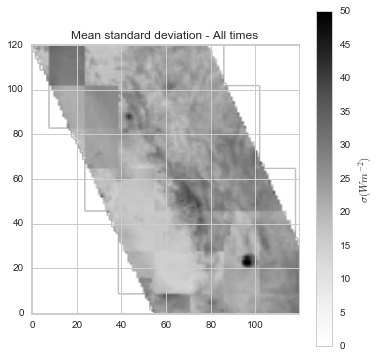

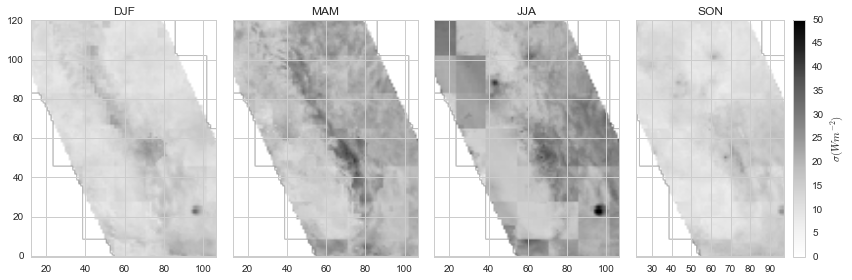

In [78]:
########################################################################
## Maps of maximum standard deviation between products
########################################################################
# Combine ensemble members into a single DataArray
ds_comb = kray.combinevars(align_ds,productNames,'product','SWdwn')

### Mean - all periods
fig,ax = plt.subplots(1,1,figsize=(6,6))
imcol = ax.imshow(ds_comb.std(dim='product').max(dim='time'),vmin=0,vmax=50,origin='lower')
colax = plt.colorbar(imcol)
colax.ax.set_ylabel('$\sigma (Wm^{-2})$')
ax.set_title('Mean standard deviation - All times')

# Print
os.chdir(dir_print)
fig.savefig('ProductMaxSTD.png')
fig.savefig('ProductMaxSTD.pdf')

### Seasonal
fig,axes = plt.subplots(1,4,sharey='row',figsize=(12,4))
seasons = ['DJF','MAM','JJA','SON']

for ax,s in zip(axes,seasons):
    # Mean - all periods
    imcol = ax.imshow(ds_comb.sel(time=(ds_comb['time.season'] == s)).std(dim='product').\
                      max(dim='time'),vmin=0,vmax=50,origin='lower')
    ax.set_title(s)
    if ax == axes[-1]:
        colax = plt.colorbar(imcol)
        colax.ax.set_ylabel('$\sigma (Wm^{-2})$')
fig.tight_layout()

# Print
os.chdir(dir_print)
fig.savefig('ProductMaxDisagreementSeasonal.png')
fig.savefig('ProductMaxDisagreementSeasonal.pdf')

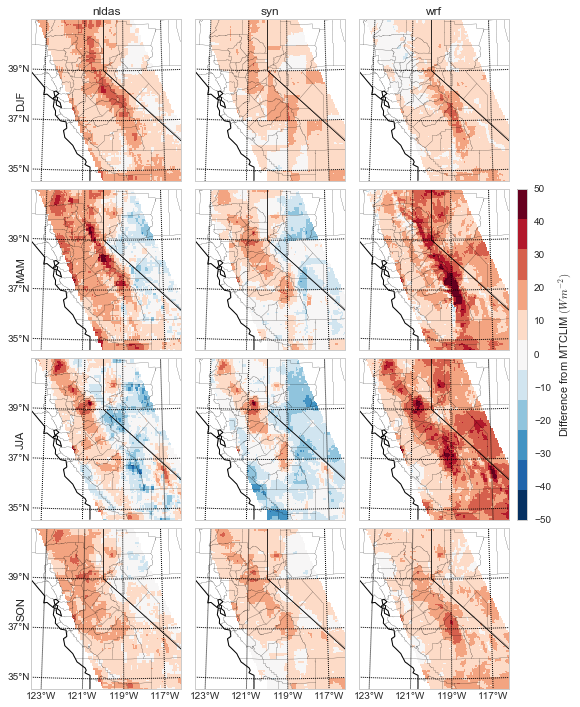

In [126]:
########################################################################
## Maps of mean difference between each product and mtclim
########################################################################

## plotting variables, coordinates, basemap
# colors
SWmin_delta = -50
SWmax_delta = 50
cmap_delta = kgraph.cmap_discretize(cm.RdBu_r,11)

# lists to iterate over
seasons = ['DJF','MAM','JJA','SON']
prN = ['nldas','syn','wrf']


# Lat/Lon handling - map extent
lonProduct,latProduct = np.meshgrid(align_ds.longitude.values,align_ds.latitude.values)
lat = align_ds.latitude.values
lon = align_ds.longitude.values
bmp,bmd = kgraph.build_basemap(lon,lat,dir_bmap,'CR.ProductRegrid.bmp.pickle',rewrite=False)
lat_labels = bmd['lat_labels']
lon_labels = bmd['lon_labels']

### Seasonal disagreement
# Create figure
fig = plt.figure(figsize=(9,12))
gs = matplotlib.gridspec.GridSpec(4,4,width_ratios=np.append(np.ones(3)*16,np.array(1.)))
gs.update(wspace=0.01,hspace=0.05)

for n,s in enumerate(seasons):
    for m,pr in enumerate(prN):
        ax = plt.subplot(gs[n,m])
        prodDiff = (align_ds[pr]-align_ds.mtclim).sel(time=(align_ds['time.season'] == s)).mean(dim='time')
        prodDiff = np.ma.masked_where(np.isnan(prodDiff),prodDiff)
        im_avg = bmp.pcolormesh(lonProduct,latProduct,prodDiff,\
                                cmap=cmap_delta,vmin=SWmin_delta,vmax=SWmax_delta,\
                                shading='flat',latlon=True,linewidth=0,rasterized=True)

        # draw boundaries.
        bmp.drawstates()
        bmp.drawcoastlines()
        bmp.drawcounties()
    
        # Format
        if n == 0:
            ax.set_title((pr))
        if m == 0:
            ax.set_ylabel(s)
            
        if m == 0:
            bmp.drawparallels(lat_labels,labels=[1,0,0,0])
        else:
            bmp.drawparallels(lat_labels)
        if n == 3:
            bmp.drawmeridians(lon_labels,labels=[0,0,0,1])
        else:
            bmp.drawmeridians(lon_labels,labels=[0,0,0,0])
        
        
# Colorbar
caxi = plt.subplot(gs[1:3,-1])
cbar = plt.colorbar(im_avg,cax=caxi, orientation='vertical',spacing='prop')
cbar.ax.set_ylabel('Difference from MTCLIM $(Wm^{-2})$')

# Print
os.chdir(dir_print)
fig.savefig('ProductDiff.mtclim.Seasonal.png')
fig.savefig('ProductDiff.mtclim.Seasonal.png')

